# FORCE Learning Tutorial

**Exercises by:** Larry Abbott<br>
**MIT tutorial organized by:** Emily Mackevicius<br>
**Notebook by:** [Alex Williams](http://alexhwilliams.info)<br>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

### Overview

This notebook provides solutions to [Larry Abbott's exercises](./FORCE_exercises.pdf) on recurrent neural networks, as part of the MIT computational neuroscience tutorial series. [Click here to see the video of Larry's lecture](http://techtv.mit.edu/collections/comp-tut/videos/32210-learning-in-recurrent-neural-networks). In contrast to Larry's notes, I've written all the equations below in matrix form. Comparing across these notations might be helpful. Any errors below are undoubtedly my own, so please bring them my attention.

### Relevant Papers

* **Original FORCE learning paper**
    * Sussillo D, Abbott LF (2009). [Generating coherent patterns of activity from chao*tic neural networks](http://dx.doi.org/10.1016/j.neuron.2009.07.018). *Neuron*. 63(4):544-57


* **Application of recurrent neural network learning to model dynamics in primate visual cortex**
    * Mante V, Sussillo D, Shenoy KV, Newsome WT (2013). [Context-dependent computation by recurrent dynamics in prefrontal cortex](http://dx.doi.org/10.1038/nature12742). *Nature*. 503(7474):78-84.
    
    
* **How recurrent neural networks respond to sinusoidal input (exercise 2)**
    * Rajan K, Abbott LF, Sompolinsky H (2010). [Stimulus-Dependent Suppression of Chaos in Recurrent Neural Networks](http://neurotheory.columbia.edu/~larry/RajanNIPS10.pdf). *Phys. Rev. E* 82:011903.

In [1]:
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,cos,pi,hstack
from numpy.random import uniform,normal,choice
import pylab as plt
import numpy as np
%matplotlib inline

### Exercise 1

Simulate the model:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} $$

with $x \in \mathcal{R}^N$ (vector), $J \in \mathcal{R}^{N \times N}$ (matrix), $g \in \mathcal{R}$ (scalar). Randomly draw each element of $J$ from a Gaussian distribution with zero mean and variance $1/N$. Characterize the output of the system for increasing values of $g$.

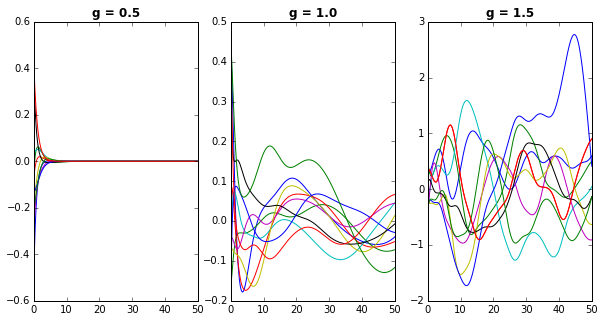

In [2]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 1000
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.5,0.5,N)
t = linspace(0,50,500)

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    plt.plot(t,x[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
plt.show()

### Exercise 2

Simulate the model with $g=1.5$ and a sinusoidal input:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} + A \cos (\omega t) \mathbf{u} $$

with $\mathbf{u} \in \mathcal{R}^N$ and each $u_i \in [-1,1]$. Vary the scalar parameters $A$ and $\omega$.

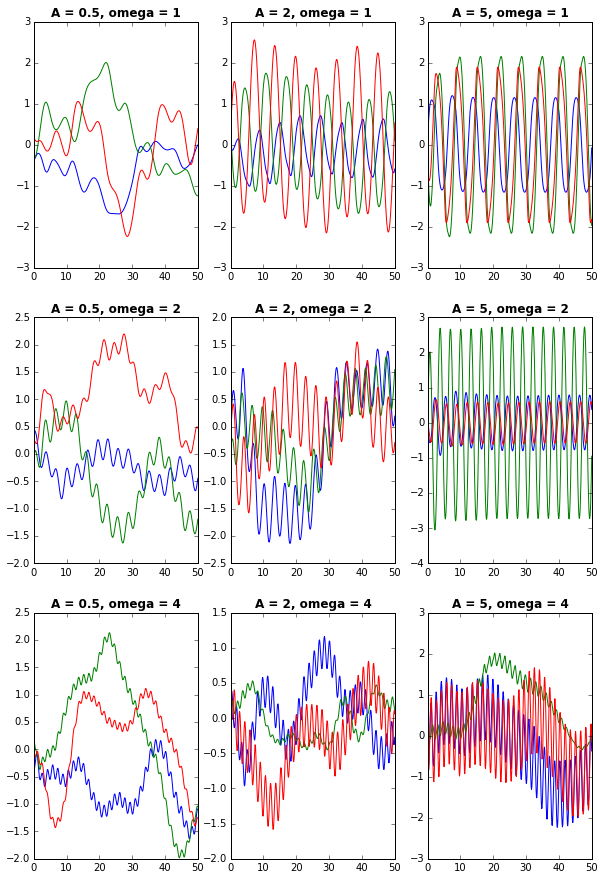

In [3]:
def f2(x,t0):
    return -x + g*dot(J,tanh(x)) + u*A*cos(o*t0)

plt.figure(figsize=(10,15))
g = 1.5
u = uniform(-1,1,N)
s = 1 # subplot index
for o in [1,2,4]:
    for A in [0.5,2,5]:
        plt.subplot(3,3,s)
        x = odeint(f2,x0,t)
        plt.plot(t,x[:,choice(N,3)])
        plt.title('A = '+str(A)+', omega = '+str(o),fontweight='bold')
        s += 1
plt.show()

### Exercise 3

Model an output or readout neuron for the network as:

$$z = \mathbf{w}^T \tanh[\mathbf{x}]$$

The output $z$ is a scalar formed by the dot product of two N-dimensional vectors ($\mathbf{w}^T$ denotes the transpose of $\mathbf{w}$). We will implement the FORCE learning rule [(Susillo & Abbott, 2009)](http://dx.doi.org/10.1016/j.neuron.2009.07.018), by adjusting the readout weights, $w_i$, so that $z$ matches a target function:

$$f(t) = \cos\left(\frac{2 \pi t}{50} \right)$$

The rule works by implementing [recursive least-squares](https://www.youtube.com/watch?v=gHSiFqO23TE):

$$\mathbf{w} \rightarrow \mathbf{w} + c(f-z) \mathbf{q}$$

$$\mathbf{q} = P \tanh [\mathbf{x}]$$

$$c = \frac{1}{1+ \mathbf{q}^T \tanh(\mathbf{x})}$$

$$P_{ij} \rightarrow P_{ij} - c q_i q_j$$

In [4]:
target = lambda t0: cos(2*pi*t0/50) # target pattern

def f3(t0,x):
    return -x + g*dot(J,tanh_x) + dot(w,tanh_x)*u

dt = 1       # time step
tmax = 800   # simulation length
w = uniform(-1/sqrt(N),1/sqrt(N),N) # initial weights
P = eye(N) # Running estimate of the inverse correlation matrix
lr = 1.0 # learning rate

# simulation data: state, output, time, weight updates
x,z,t,wu = [x0],[],[0],[0]

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1]) # cache 
    z.append(dot(w,tanh_x))
    error = target(t[-1]) - z[-1]
    q = dot(P,tanh_x)
    c = lr / (1 + dot(q,tanh_x))
    P = P - c*outer(q,q)
    w = w + c*error*q
    
    if t[-1]>300: lr = 0
    
    wu.append(np.sum(np.abs(c*error*q)))
    
    solver.integrate(solver.t+dt)
    x.append(solver.y)
    t.append(solver.t)
    
# last update for readout neuron
z.append(dot(w,tanh_x))

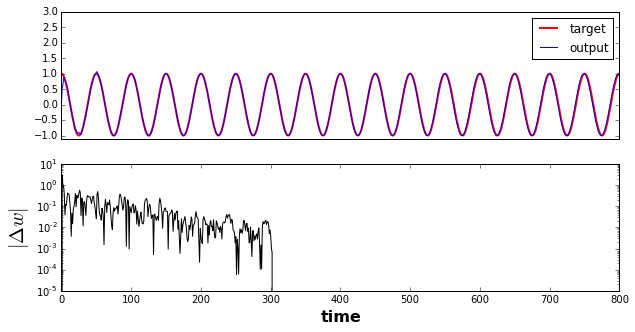

In [5]:
x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,target(t),'-r',lw=2)
plt.plot(t,z,'-b')
plt.legend(('target','output'))
plt.ylim([-1.1,3])
plt.xticks([])
plt.subplot(2,1,2)
plt.plot(t,wu,'-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$',fontsize=20)
plt.xlabel('time',fontweight='bold',fontsize=16)
plt.show()